In [672]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as ss
import spacy

In [674]:
col_names = None
col_question = None
data = []
with open("dataset1.csv") as f:
    csv_reader = csv.reader(f, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            col_names = row
        elif line_count == 1:
            col_question = row
        else:
            data.append(row)
        line_count += 1

df = pd.DataFrame(data, columns=col_names)

In [675]:
print(df.shape)

(9008, 22)


In [676]:
col_name_mappings = {}
for i in range(len(col_names)):
    col_name_mappings[col_names[i]] = col_question[i].strip()

In [677]:
df = df[df['Q45'] != '']

In [678]:
written_responses = df.pop('Q45')

In [679]:
df = df.reindex(sorted(df.columns), axis=1)

In [680]:
# dataset shape
print(df.shape)

(5530, 21)


In [681]:
# Q9 ethnicity
# Q7 gender
# Q8 age

### Categorical Questions

In [682]:
df['Q9'] = df['Q9'].apply(lambda x: x if x != '' else 'other')

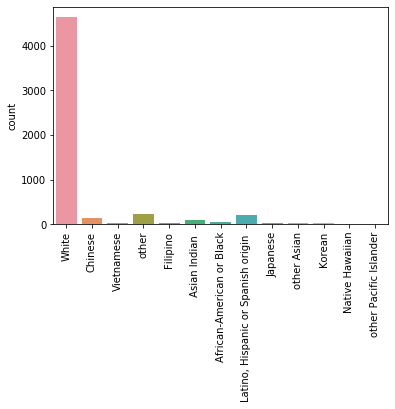

In [683]:
plot = sns.countplot([x for x in df['Q9'] if x != ''])
plot = plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

In [684]:
for e in list(set(df['Q9'])):
    print(e, len(df[df['Q9'] == e]))

other Pacific Islander 5
Korean 24
Latino, Hispanic or Spanish origin  216
Chinese 152
African-American or Black 60
Japanese 19
 Asian Indian  106
Vietnamese 18
other Asian 33
White 4636
Native Hawaiian 2
other 232
Filipino 27


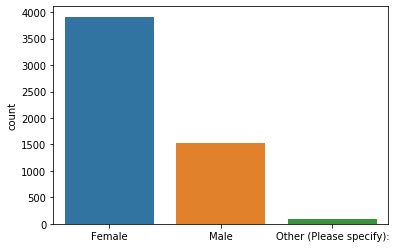

In [685]:
df['Q7'] = df['Q7'].apply(lambda x: x if x != '' else 'Other (Please specify):')
plot = sns.countplot([x for x in df['Q7'] if x != ''])

In [686]:
for e in list(set(df['Q7'])):
    print(e, len(df[df['Q7'] == e]))

Female 3914
Other (Please specify): 83
Male 1533


Average age: 48.14504094631483
Median age: 47.0
Standard deviation: 14.240718781162236


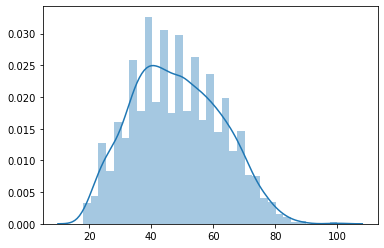

In [687]:
ages = []
for age in df['Q8']:
    if age != '':
        ages.append(2020 - int(age))
sns.distplot(ages)
print("Average age:", np.mean(ages))
print("Median age:", np.median(ages))
print("Standard deviation:", np.std(ages))

### NLP

In [688]:
from nltk.corpus import stopwords
import nltk
import spacy
import dlatk
import fasttext
from collections import Counter

In [712]:
stop_words = set(stopwords.words('english')) 
nlp = spacy.load("en_core_web_lg")

In [1052]:
def normalize(comment, lowercase=True, remove_stopwords=True):
    if lowercase:
        comment = comment.lower()
    comment = ' '.join(comment.split())
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if not remove_stopwords or (remove_stopwords and lemma not in stop_words):
            lemmatized.append(lemma)
    return lemmatized

def convert_to_txt(d):
    txt = ""
    for response in d:
        tokens = normalize(response)
        all_words = [token for token in tokens if token.isalnum()]
        txt += " ".join(all_words) + " "
    return txt

def format_nn(nn, K=3):
    for score, word in nn[:K]:
        print(str(round(score, 4)), word)
        
def compare_wc(word, model1, model2):
    format_nn(model1.get_nearest_neighbors(word))
    print("\n")
    format_nn(model2.get_nearest_neighbors(word))

In [732]:
written_responses.head()

0    I’ve self-quarantined with my husband and 1 ye...
2    I’m starting to avoid going out but am honestl...
3    Our administration is handling this in the wor...
4    I am working from home and no longer going to ...
5    I work in healthcare as a physical therapist. ...
Name: Q45, dtype: object

In [715]:
written_responses_len = written_responses.apply(lambda x: len(x.split()))
written_responses_unique = written_responses.apply(lambda x: len(set(x.split())))

In [716]:
print(np.mean(written_responses_len), np.median(written_responses_len))

63.51139240506329 41.0


In [717]:
print(np.mean(written_responses_unique), np.median(written_responses_unique))

48.34593128390597 36.0


In [1012]:
all_responses = ""
cleaned_responses = ""
for response in written_responses:
    tokens = normalize(response, remove_stopwords=False)
    all_words = [token for token in tokens if token.isalnum()]
    cleaned_words= [token for token in all_words if token not in stop_words]
    all_responses += " ".join(all_words) + " "
    cleaned_responses += " ".join(cleaned_words) + " "

In [1013]:
total_counter = Counter(cleaned_responses.split())
print("5 most common words:", total_counter.most_common(5))

5 most common words: [('work', 3166), ('home', 3035), ('go', 2050), ('get', 1692), ('week', 1541)]


In [859]:
with open("all_responses.txt", "w") as f:
    f.write(all_responses)

In [699]:
model = fasttext.load_model("result/fil9.bin")

In [957]:
survey_model = fasttext.train_unsupervised("all_responses.txt", dim=25)

In [1007]:
interested_words = ['work', 'home', 'go', 'get', 'week', 'people', 'future', 'family']

In [1008]:
for word in interested_words:
    print(word, total_counter[word])
    compare_wc(word, survey_model, model)
    print("\n")

work 3166
0.8759 workforce
0.8756 workplace
0.8713 teleworke


0.8201 works
0.679 writing
0.6777 wrote


home 3035
0.8907 from
0.8663 stay
0.8616 teenager


0.6942 althouse
0.6927 fieldhouse
0.6866 natick


go 2050
0.8985 out
0.8823 takeout
0.8556 stop


0.7847 going
0.7723 get
0.7241 thankyou


get 1692
0.8629 sick
0.8592 cat
0.8525 aid


0.8309 getting
0.7975 going
0.7723 go


week 1541
0.9163 least
0.9086 3
0.8973 last


0.8354 month
0.7927 weekend
0.7872 weeks


people 1172
0.9307 helpless
0.9174 paranoia
0.9064 particularly


0.7588 demographers
0.6812 lians
0.6803 persons


future 188
0.855 uncertain
0.8489 disrupt
0.8431 uncertainty


0.7456 foreseeable
0.7093 foresee
0.7028 past


family 1241
0.8844 elderly
0.8815 eld
0.8667 friend


0.853 xfamily
0.7875 stepfamily
0.7322 household




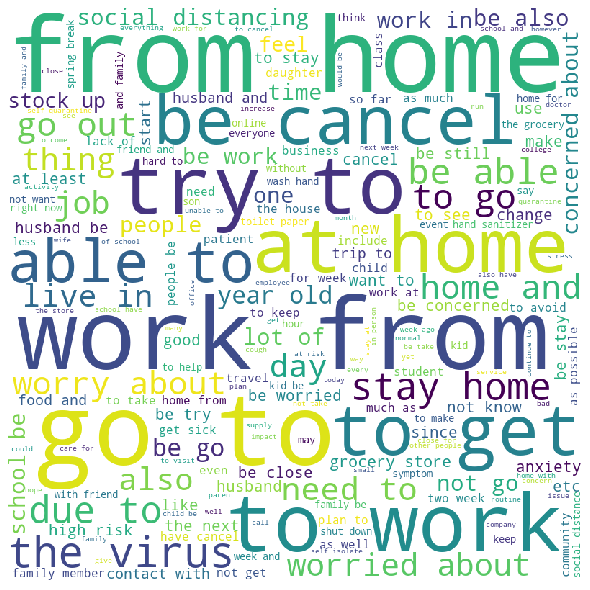

In [1015]:
# importing all necessery modules 
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import pandas as pd 
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10)

wordcloud = wordcloud.generate(all_responses) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### splitting by gender

In [1016]:
written_responses['gender'] = df['Q7']

In [1017]:
responses_df = pd.DataFrame(written_responses)

In [1018]:
responses_df['gender'] = df['Q7']

In [1019]:
female_responses = responses_df[responses_df['gender'] == 'Female']['Q45']
male_responses = responses_df[responses_df['gender'] == 'Male']['Q45']

In [1073]:
print(len(female_responses), len(male_responses))

3914 1533


In [1053]:
female_converted = convert_to_txt(female_responses)
male_converted = convert_to_txt(male_responses)

In [1054]:
with open("female_responses.txt", "w") as f:
    f.write(female_converted)
    
with open("male_responses.txt", "w") as f:
    f.write(male_converted)

In [1055]:
female_response_model = fasttext.train_unsupervised("female_responses.txt")
male_response_model = fasttext.train_unsupervised("male_responses.txt")

In [1056]:
len(female_response_model.words)

2558

In [1057]:
len(male_response_model.words)

1325

In [1058]:
print(set(female_response_model.words) - set(male_response_model.words))

{'dire', 'graduation', 'protection', 'freshman', '96', 'awhile', 'fruit', 'convention', 'preschool', 'horribly', 'handwashing', 'ipad', 'luck', 'bank', 'concrete', 'explain', 'sibling', 'view', 'dwindle', 'massachusetts', 'tree', 'cousin', 'metro', 'ocd', 'distress', 'taxis', 'shower', 'weak', 'suffering', 'qualify', 'hotspot', 'aged', 'fox', 'oil', 'transport', 'mode', 'journalist', 'threat', 'vegas', 'grandma', 'adjustment', 'tonight', 'hire', 'pile', 'michigan', 'condo', 'thoroughly', 'word', 'airbnb', 'conflict', 'zoo', 'advance', 'researcher', 'hubby', 'recovery', 'media', 'panicked', 'singapore', '78', 'infectious', 'sub', 'goat', 'playdate', 'european', 'land', 'false', 'rice', 'bedroom', 'exhausted', 'tech', 'gig', 'unnecessarily', '28', '6th', '66', '27', '85', 'ignorant', 'box', 'actual', 'introvert', 'festival', 'theater', 'hike', 'chat', 'pocket', 'recreational', 'preventative', 'exhaust', '73', 'range', 'writing', 'overly', 'ohio', 'legal', 'considerable', 'session', 'otc'

In [1059]:
print(set(male_response_model.words) - set(female_response_model.words))

{'n', 'denver', 'excuse', 'oklahoma', 'suck', 'evolve', 'cardiac', 'corvallis', 'mucus', 'strain', 'consultant', 'asia', 'portfolio', 'substantial', 'sanitation', 'sars', 'surge', 'marathon', 'rapidly', 'male', '101', 'fuck', 'lazzat', 'holiday', '102', 'construction', 'uk', 'confident', 'november', 'paranoia', 'minimally', 'sanitary'}


In [1071]:
female_counter = Counter(female_converted.split())
male_counter = Counter(male_converted.split())

In [1072]:
print(female_counter.most_common(5))
print(male_counter.most_common(5))

[('work', 2444), ('home', 2340), ('go', 1572), ('get', 1315), ('school', 1191)]
[('work', 669), ('home', 668), ('go', 459), ('get', 349), ('week', 348)]


In [1075]:
# average unique words per response
unique = []
total = []
for response in female_responses:
    unique.append(len(set(response.split())))
    total.append(len(response.split()))
print("Average total words in female response", np.mean(total))
print("Average unique words in female response:", np.mean(unique))
print("Stddev:", np.std(unique))

unique = []
total = []
for response in male_responses:
    unique.append(len(set(response)))
    total.append(len(response.split()))
print("Average total words in male response", np.mean(total))
print("Average unique words in male response:", np.mean(unique))
print("Stddev:", np.std(unique))

Average total words in female response 68.58610117526827
Average unique words in female response: 51.76290240163516
Stddev: 46.045516275666536
Average total words in male response 50.4631441617743
Average unique words in male response: 28.743639921722114
Stddev: 8.56791487790432


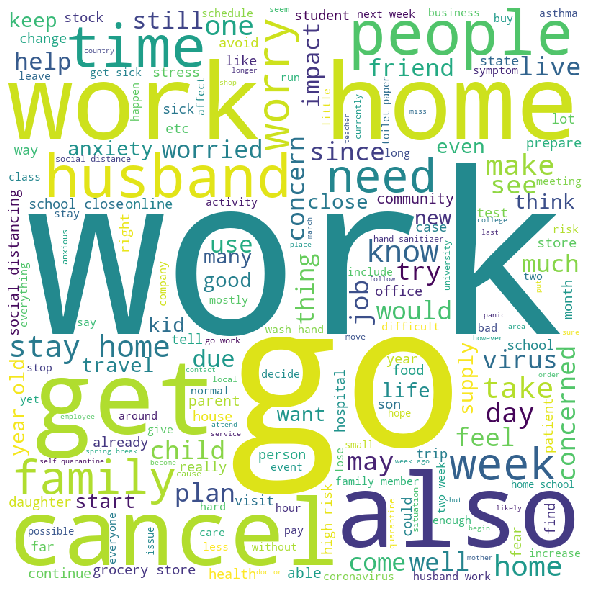

In [1063]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10)

wordcloud = wordcloud.generate(female_converted) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

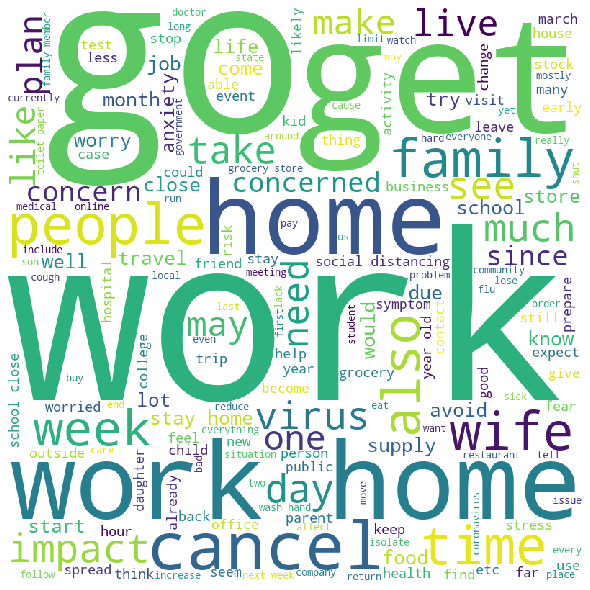

In [1064]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10)

wordcloud = wordcloud.generate(male_converted) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### splitting by ethnicity

In [1065]:
responses_df['ethnicity'] = df['Q9']

In [1066]:
ethnicities = list(set(responses_df['ethnicity']))
ethnicities

[nan,
 'other Pacific Islander',
 'Korean',
 'Latino, Hispanic or Spanish origin ',
 'Chinese',
 'African-American or Black',
 'Japanese',
 ' Asian Indian ',
 'Vietnamese',
 'other Asian',
 'White',
 'Native Hawaiian',
 'other',
 'Filipino']

In [1067]:
ethnicity_map = {
 'other Pacific Islander': 'Asian',
 'Korean': 'Asian',
 'Latino, Hispanic or Spanish origin ': 'Latino',
 'Chinese': 'Asian',
 'African-American or Black': 'African-American',
 'Japanese': 'Asian',
 'Filipino': 'Asian',
 'Vietnamese': 'Asian',
 'other Asian': 'Asian',
 'White': 'White',
 'Native Hawaiian': 'Asian',
 'other': 'Other',
 ' Asian Indian ': 'Asian',
 'Chamorro': 'Other',
 '': 'Other'
}

In [1068]:
responses_df['ethnicity'] = df['Q9'].apply(lambda x: ethnicity_map[x])
ethnicities = list(set(ethnicity_map.values()))

Other
[('work', 149), ('home', 106), ('get', 87), ('go', 68), ('people', 63)]


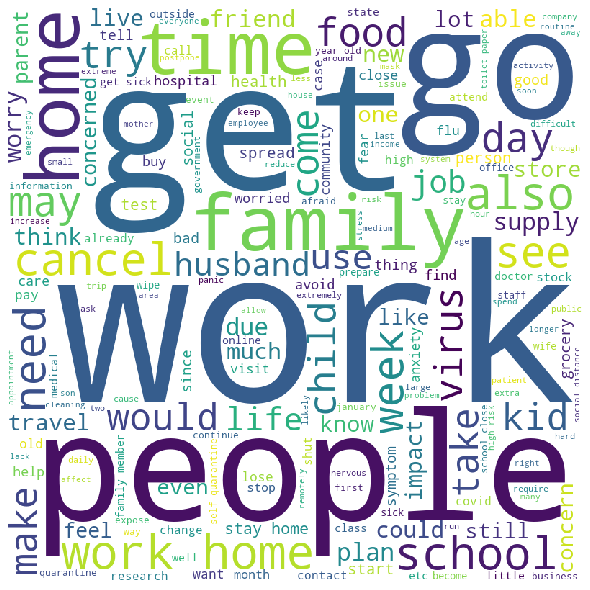

Asian
[('work', 211), ('home', 206), ('go', 172), ('get', 102), ('social', 99)]


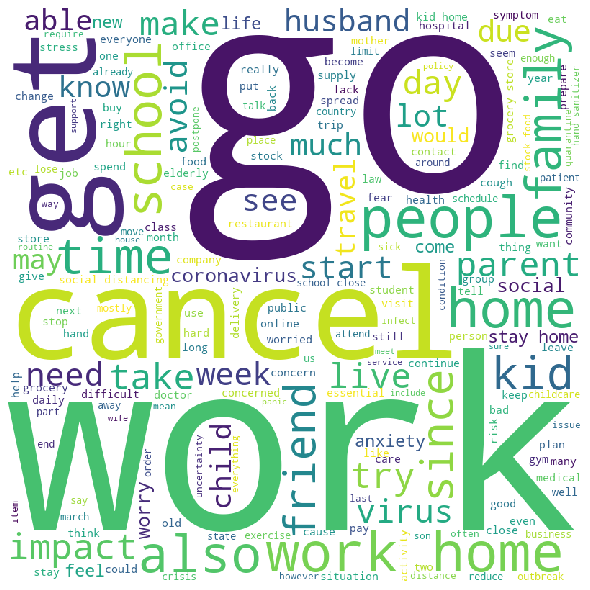

Latino
[('work', 157), ('home', 106), ('go', 75), ('get', 60), ('week', 58)]


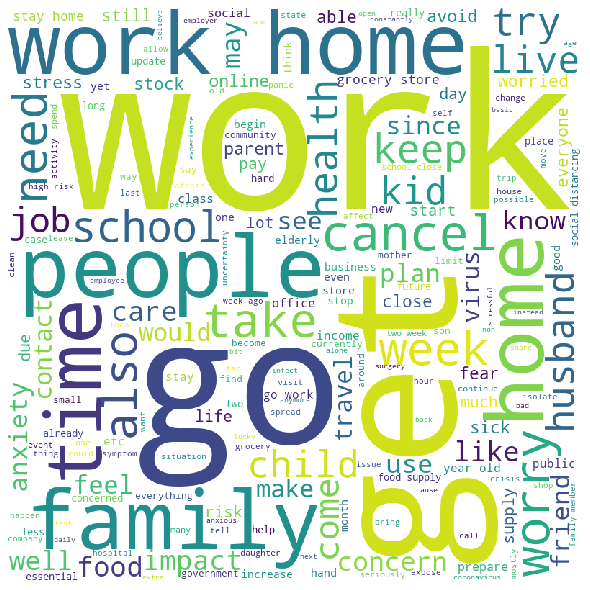

White
[('work', 2619), ('home', 2591), ('go', 1722), ('get', 1431), ('week', 1345)]


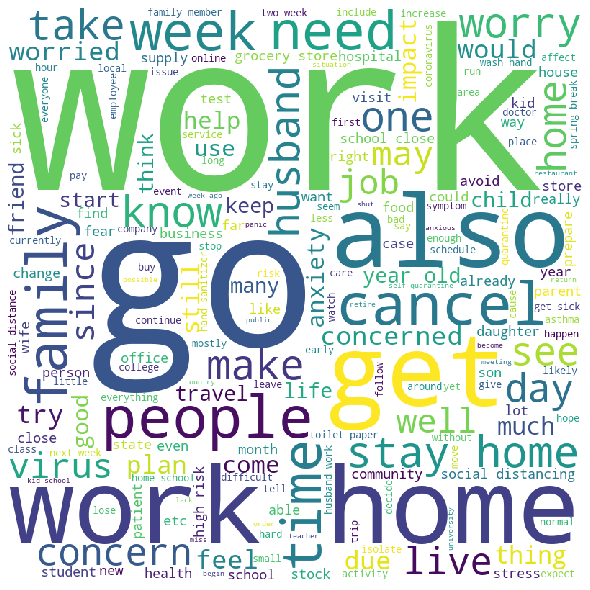

African-American
[('work', 30), ('home', 26), ('also', 14), ('family', 13), ('people', 13)]


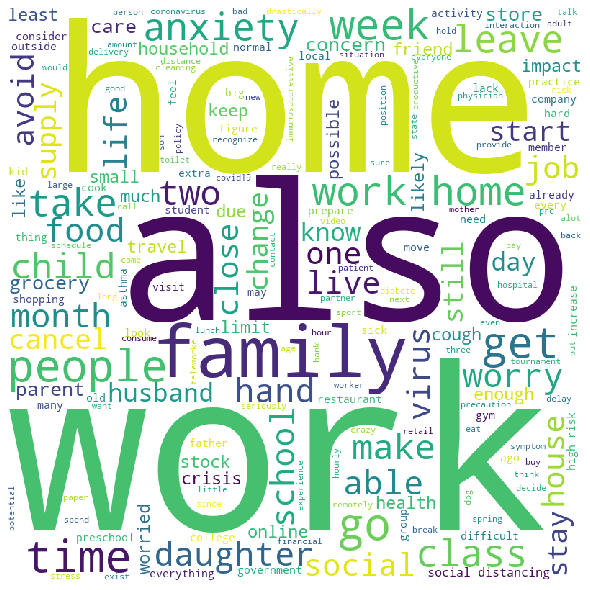

In [1077]:
most_common_words = set()
ethnicity_models = {}
for e in ethnicities:
    print(e)
    e_responses = responses_df[responses_df['ethnicity'] == e]['Q45']
    txt_response = convert_to_txt(e_responses)
    filtered_response = [w for w in txt_response.split() if not w in stop_words]
    counter = Counter(filtered_response)
    most_common = counter.most_common(5)
    print(most_common)
    for word, count in most_common:
        most_common_words.add(word)
        
    with open(e + ".txt", "w") as f:
        f.write(txt_response)
        
    ethnicity_models[e] = fasttext.train_unsupervised(e + ".txt", dim=25)

    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10)

    wordcloud = wordcloud.generate(' '.join(filtered_response))

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

In [1078]:
for word in most_common_words:
    print(word)
    for e, model in ethnicity_models.items():
        print(e)
        format_nn(model.get_nearest_neighbors(word))
        print('\n')

social
Other
0.9999 socially
0.9997 normally
0.9997 vulnerable


Asian
0.9998 socially
0.9998 socialize
0.9997 take


Latino
0.9998 interaction
0.9998 affect
0.9998 month


White
0.9657 distancing
0.9552 distance
0.941 practice


African-American
0.9996 parent
0.9996 husband
0.9995 hand


week
Other
0.9998 shortage
0.9998 illness
0.9997 event


Asian
0.9998 quarantine
0.9997 group
0.9997 continue


Latino
0.9998 experience
0.9998 share
0.9997 house


White
0.9793 weekend
0.9781 3
0.9777 month


African-American
0.9997 stay
0.9996 husband
0.9996 home


go
Other
0.9993 change
0.9993 little
0.9993 contract


Asian
0.9995 ago
0.9995 wfh
0.9995 gathering


Latino
0.999 learn
0.999 cause
0.999 online


White
0.9706 book
0.9703 freshman
0.966 nearby


African-American
0.9994 social
0.9994 make
0.9994 anxiety


work
Other
0.9997 worried
0.9997 emergency
0.9997 extremely


Asian
0.9997 worker
0.9996 york
0.9995 daycare


Latino
0.9997 situation
0.9996 employer
0.9996 precaution


White
0.9447 c

### split by age

In [1098]:
bins = [0, 17, 31, 44, 64, 100]
df['age'] = 2020 - df['Q8'].apply(lambda x: int(x) if x != '' else -1)
responses_df['age'] = pd.cut(df['age'], bins=bins)

In [1099]:
responses_df.head()

,Q45,gender,ethnicity,age
0,I’ve self-quarantined with my husband and 1 ye...,Female,White,"(31, 44]"
2,I’m starting to avoid going out but am honestl...,Male,Asian,"(31, 44]"
3,Our administration is handling this in the wor...,Male,White,"(31, 44]"
4,I am working from home and no longer going to ...,Female,Asian,"(31, 44]"
5,I work in healthcare as a physical therapist. ...,Female,White,"(31, 44]"


In [1100]:
age_buckets = list(set(responses_df['age']))

In [1101]:
age_buckets.pop(0)
age_buckets.sort()

(17.0, 31.0]
[('work', 393), ('home', 248), ('go', 240), ('get', 217), ('also', 177)]


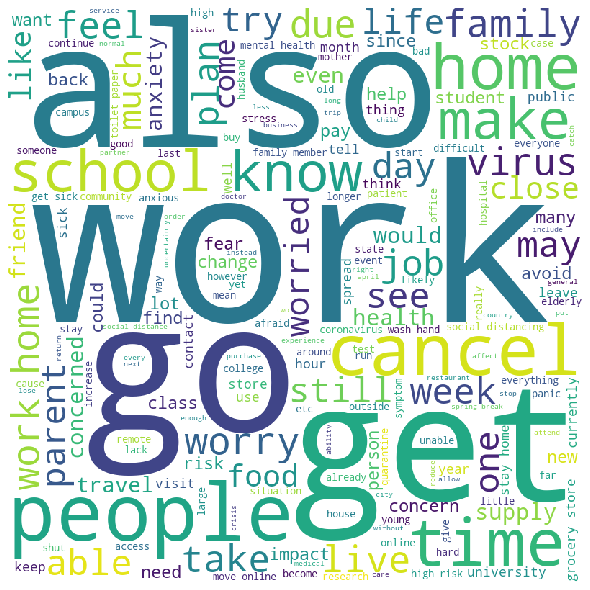

(31.0, 44.0]
[('work', 1105), ('home', 993), ('go', 596), ('school', 509), ('get', 491)]


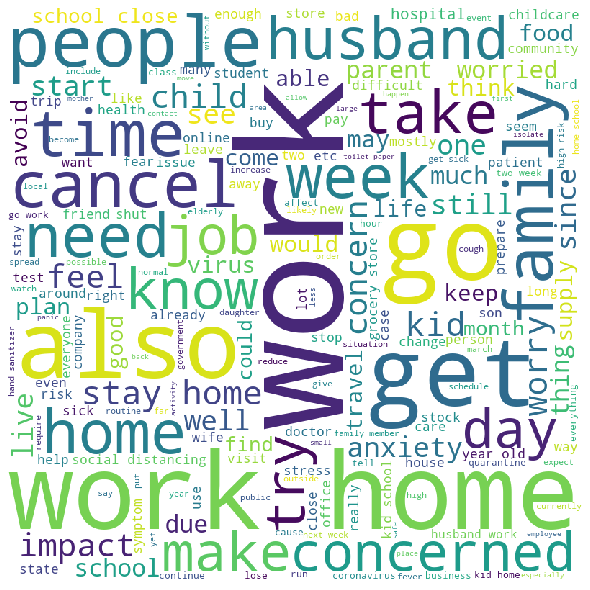

(44.0, 64.0]
[('work', 1466), ('home', 1450), ('go', 861), ('school', 802), ('get', 770)]


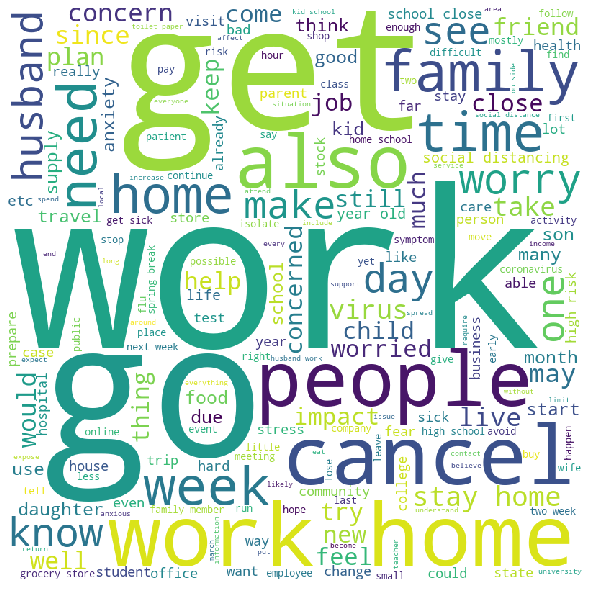

(64.0, 100.0]
[('go', 342), ('home', 326), ('cancel', 239), ('get', 206), ('week', 185)]


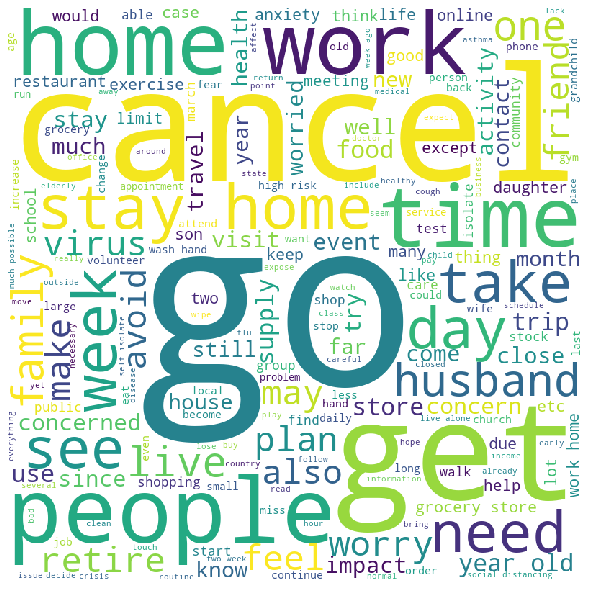

In [1102]:
most_common_words = set()
age_models = {}
for e in age_buckets:
    print(e)
    e_responses = responses_df[responses_df['age'] == e]['Q45']
    txt_response = convert_to_txt(e_responses)
    filtered_response = [w for w in txt_response.split() if not w in stop_words]
    counter = Counter(filtered_response)
    most_common = counter.most_common(5)
    print(most_common)
    for word, count in most_common:
        most_common_words.add(word)
        
    with open(str(e) + ".txt", "w") as f:
        f.write(txt_response)
        
    age_models[e] = fasttext.train_unsupervised(str(e) + ".txt", dim=25)

    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10)

    wordcloud = wordcloud.generate(' '.join(filtered_response))

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

In [1127]:
for word in list(most_common_words) + ['worry', 'people', 'time', 'online', 'test', 'cough']:
    print(word)
    for e, model in age_models.items():
        print(e)
        format_nn(model.get_nearest_neighbors(word))
        print('\n')

week
(17.0, 31.0]
0.9996 weekly
0.9996 return
0.9996 shopping


(31.0, 44.0]
0.999 weekend
0.9989 weekly
0.9989 lunch


(44.0, 64.0]
0.9948 weekend
0.9913 monday
0.9913 friday


(64.0, 100.0]
0.9996 deliver
0.9995 weather
0.9995 employer


cancel
(17.0, 31.0]
0.9998 cancer
0.9997 unknown
0.9997 limited


(31.0, 44.0]
0.9985 dance
0.9983 distance
0.9982 extend


(44.0, 64.0]
0.9906 cancer
0.99 homeschoole
0.9897 trip


(64.0, 100.0]
0.9998 cancer
0.9996 performance
0.9996 outdoors


go
(17.0, 31.0]
0.9989 cleaning
0.9988 idea
0.9988 teaching


(31.0, 44.0]
0.9984 something
0.9981 shower
0.9981 staple


(44.0, 64.0]
0.9972 start
0.9971 bind
0.997 stuff


(64.0, 100.0]
0.9993 allow
0.9993 research
0.9992 wear


work
(17.0, 31.0]
0.9996 productivity
0.9996 worry
0.9996 employment


(31.0, 44.0]
0.9984 telework
0.9979 closely
0.9978 closed


(44.0, 64.0]
0.9908 telework
0.9895 student
0.988 district


(64.0, 100.0]
0.9996 workout
0.9996 face
0.9996 miss


also
(17.0, 31.0]
0.9999 domestic
0